In [148]:
# 导入库
import os
import numpy as np
from typing import List, Tuple, Dict
from sentence_transformers import SentenceTransformer
from openai import OpenAI
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [149]:
# 通用函数：获取嵌入 (支持本地 & API)
def get_embeddings(texts: List[str], model_name: str, use_local: bool = False) -> np.ndarray:
    if use_local:

        model = SentenceTransformer(model_name,trust_remote_code=True)
        # 本地模型支持直接归一化
        return model.encode(texts,
                            normalize_embeddings=True)
    else:
        client = OpenAI(api_key=os.getenv("API_KEY"), base_url=os.getenv("BASE_URL"))
        resp = client.embeddings.create(input=texts, model=model_name)
        emb = np.array([d.embedding for d in resp.data])
        return emb

In [150]:
# 计算余弦相似度
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

In [151]:
# 运行实验函数
def run_experiment(pairs: List[Tuple[str, str]], model_name: str, use_local: bool = False) -> Dict[str, float]:
    texts = [p[0] for p in pairs] + [p[1] for p in pairs]
    embeddings = get_embeddings(texts, model_name, use_local)
    n = len(pairs)
    results: Dict[str, float] = {}
    for i, (a, b) in enumerate(pairs):
        sim = cosine_similarity(embeddings[i], embeddings[i + n])
        results[f"{a} vs {b}"] = sim
    return results

In [152]:
from matplotlib.patches import Patch

# 可视化函数
def plot_results(results: Dict[str, float], title: str):
    """
    可视化实验结果（余弦相似度），并用颜色标示与第一个结果的差异。

    Args:
        results: 一个字典，键是比较的句子对描述（字符串），值是对应的余弦相似度（浮点数）。
        title: 图表的标题（字符串）。
    """
    keys = list(results.keys())
    vals = list(results.values())

    if not vals: # 处理空结果的情况
        print("No results to plot.")
        return

    # 创建图表，设置更合适的画布大小
    fig, ax = plt.subplots(figsize=(12, 6)) # 使用 fig, ax

    # 定义颜色
    base_color = 'lightblue'
    higher_color = 'lightcoral' # 比基准高的颜色
    lower_color = 'lightgreen' # 比基准低的颜色

    # 获取基准值（第一个柱子的高度）
    base_value = vals[0]

    # 绘制条形图，并根据与基准值的比较设置颜色
    colors = [base_color] # 第一个柱子用基准色
    for val in vals[1:]:
        if val > base_value:
            colors.append(higher_color)
        elif val < base_value:
            colors.append(lower_color)
        else:
            colors.append(base_color) # 与基准值相等也用基准色

    bars = ax.bar(keys, vals, color=colors, width=0.6)

    # 设置图表标题，并调整字体大小
    ax.set_title(title, fontsize=16, pad=20)

    # 设置Y轴范围，留出顶部空间显示数值
    ax.set_ylim(0, max(vals) * 1.15 if vals else 1.1) # 动态调整Y轴上限
    # 添加Y轴标签
    ax.set_ylabel("余弦相似度", fontsize=12)

    # 设置X轴刻度标签，旋转角度以便阅读，并调整字体大小
    ax.set_xticks(ax.get_xticks()) # Ensure ticks are set before setting labels
    ax.set_xticklabels(keys, rotation=30, ha='right', fontsize=10) # 调整旋转角度

    # 添加水平网格线，设置样式和透明度，提高可读性
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7) # 使用虚线网格

    # 在每个条形上方精确显示数值和内部显示与基准的差异
    for i, bar in enumerate(bars):
        y = bar.get_height()
        # 显示数值 (在柱子上方)
        ax.text(bar.get_x() + bar.get_width() / 2, y + 0.01, f"{y:.3f}",
                 ha='center', va='bottom', fontsize=9)
        # 显示与基准的差异（第一个柱子除外，显示在柱子内部靠近顶部）
        if i > 0:
            diff = y - base_value
            diff_text = f"{diff:+.3f}" # 带符号显示差异
            diff_color = 'red' if diff < 0 else 'green' if diff > 0 else 'gray'
            # 将差异文本放在柱子内部，稍微低于顶部
            ax.text(bar.get_x() + bar.get_width() / 2, y - 0.01, diff_text,
                     ha='center', va='top', fontsize=8, color=diff_color, fontweight='bold') # va='top' 确保文本在指定y坐标下方

    # 添加图例说明颜色含义，并将其放置在图表外部右侧
    legend_elements = [Patch(facecolor=base_color, edgecolor='gray', label=f'基准值 ({vals[0]:.3f})'),
                       Patch(facecolor=higher_color, edgecolor='gray', label='高于基准'),
                       Patch(facecolor=lower_color, edgecolor='gray', label='低于基准')]
    # 将图例放置在轴域 (Axes) 的右上方外部
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10, borderaxespad=0.)


    # 自动调整子图参数，使之填充整个图像区域，防止标签重叠
    # 使用 fig.tight_layout() 或 plt.tight_layout()
    fig.tight_layout(pad=1.5) # 增加一点填充

    # 显示图表
    plt.show()

实验1 API模型结果:
{'小狗在追球。 vs 小狗在玩耍。': 0.8263500138512831, '小狗在追球。 它在公园的草地上兴奋地追逐一个红色的球。 vs 小狗在玩耍。': 0.7516349572946573}


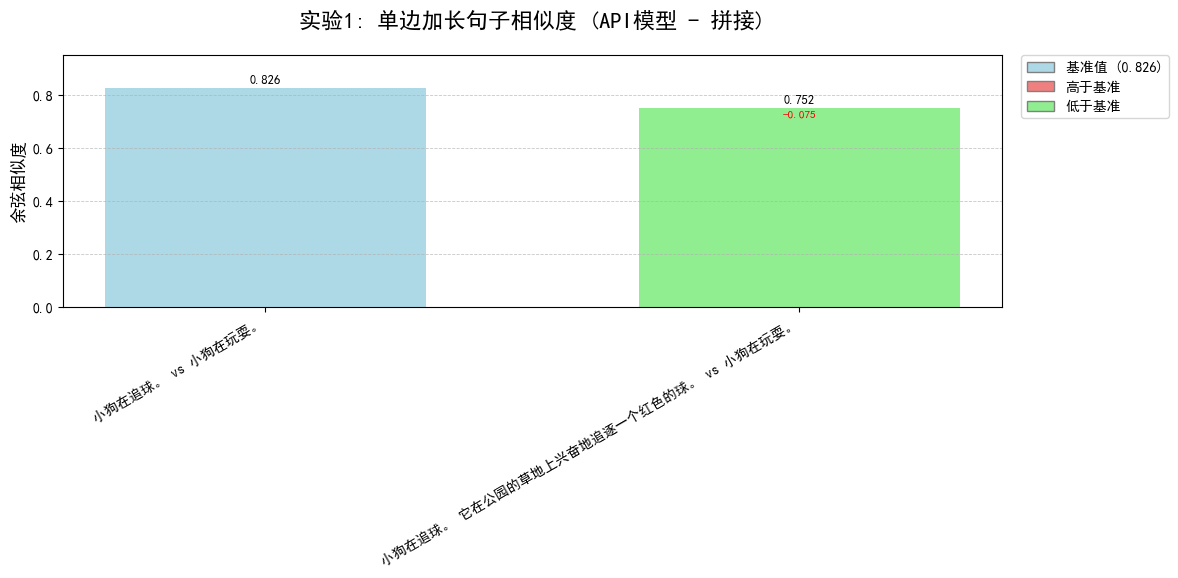

In [153]:
# 实验1: 单边加长句子 (优化版 - 拼接加长)

# 基础对
s1_base = "小狗在追球。"
s2_base = "小狗在玩耍。"
# 单边加长 (拼接)
s1_long_append = s1_base + " 它在公园的草地上兴奋地追逐一个红色的球。"

pairs = [
    (s1_base, s2_base),           # 基础对
    (s1_long_append, s2_base),    # s1 拼接加长
]

# 使用API模型运行实验 (示例)
res = run_experiment(pairs, model_name="BAAI/bge-m3", use_local=False)
print("实验1 API模型结果:")
print(res)
# 可视化
plot_results(res, "实验1: 单边加长句子相似度 (API模型 - 拼接)")

In [154]:
bge_m3_model_path = "C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-m3"



实验1 本地模型结果:
{'小狗在追球。 vs 小狗在玩耍。': 0.8268042206764221, '小狗在追球。 它在公园的草地上兴奋地追逐一个红色的球。 vs 小狗在玩耍。': 0.7518507242202759}


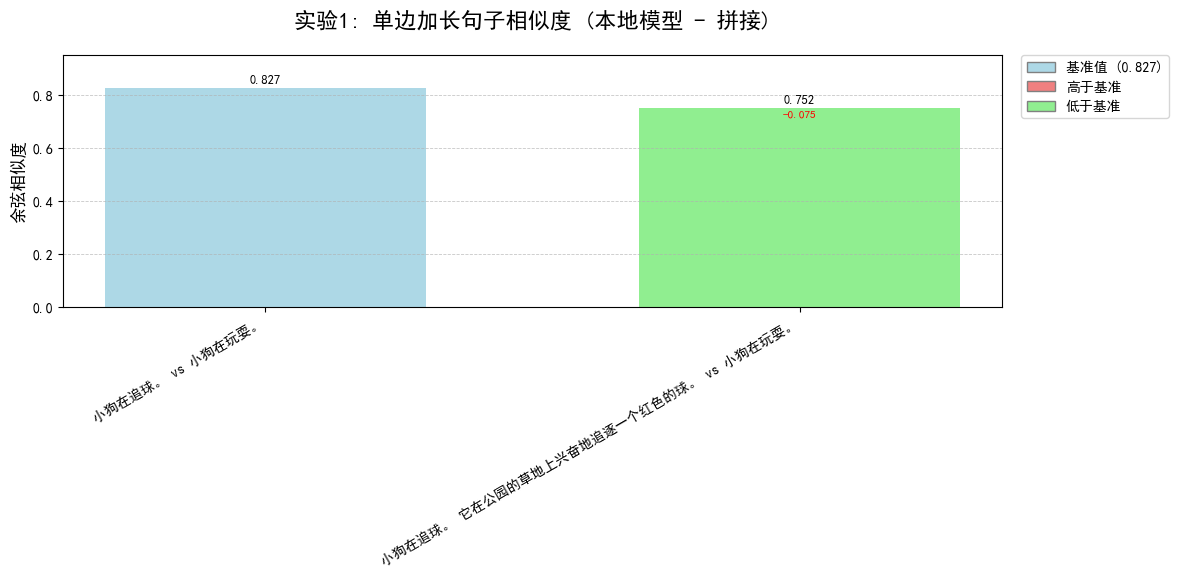

In [155]:
# 实验1: 使用本地模型 (优化版 - 拼接加长)
# (pairs 变量已在上一单元格定义)
res_local = run_experiment(pairs, model_name=bge_m3_model_path, use_local=True)
print("\n实验1 本地模型结果:")
print(res_local)
# 可视化
plot_results(res_local, "实验1: 单边加长句子相似度 (本地模型 - 拼接)")

实验2 本地模型结果:
{'学习编程很有用。 vs 它可以帮助解决问题。': 0.6839863657951355, '学习编程很有用。 vs 它可以帮助解决问题。 它可以帮助我们更高效地解决复杂的计算和逻辑问题。': 0.6648806929588318, '学习编程很有用。 vs 它可以帮助解决问题。 就像多喝水对身体好一样。': 0.6743142008781433}


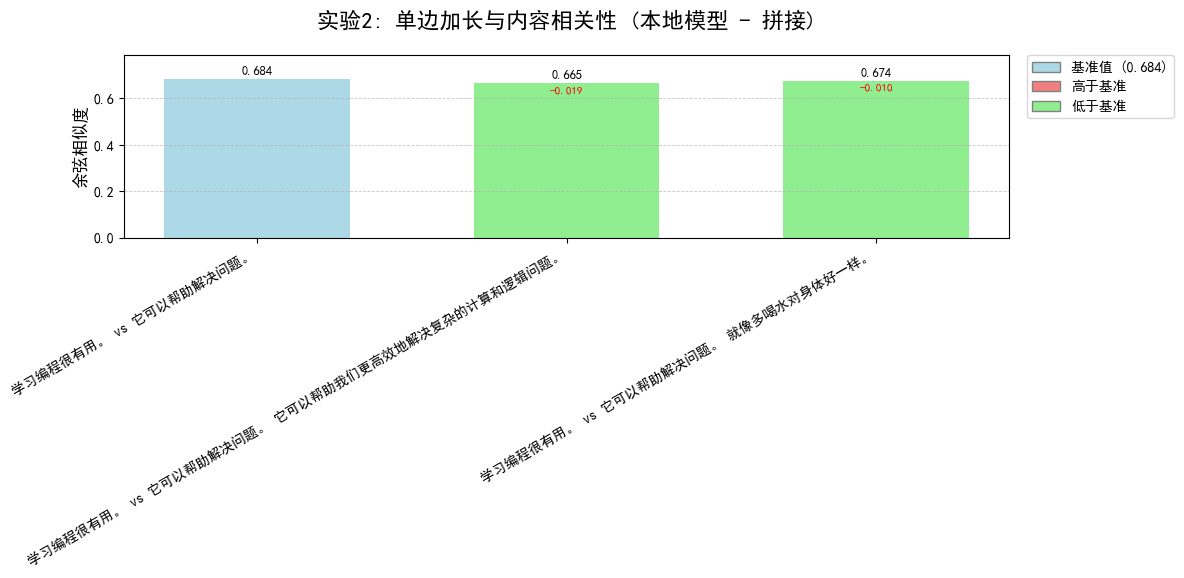


实验2 API模型结果:
{'学习编程很有用。 vs 它可以帮助解决问题。': 0.6836112930823162, '学习编程很有用。 vs 它可以帮助解决问题。 它可以帮助我们更高效地解决复杂的计算和逻辑问题。': 0.6646221407796157, '学习编程很有用。 vs 它可以帮助解决问题。 就像多喝水对身体好一样。': 0.6742919964692892}


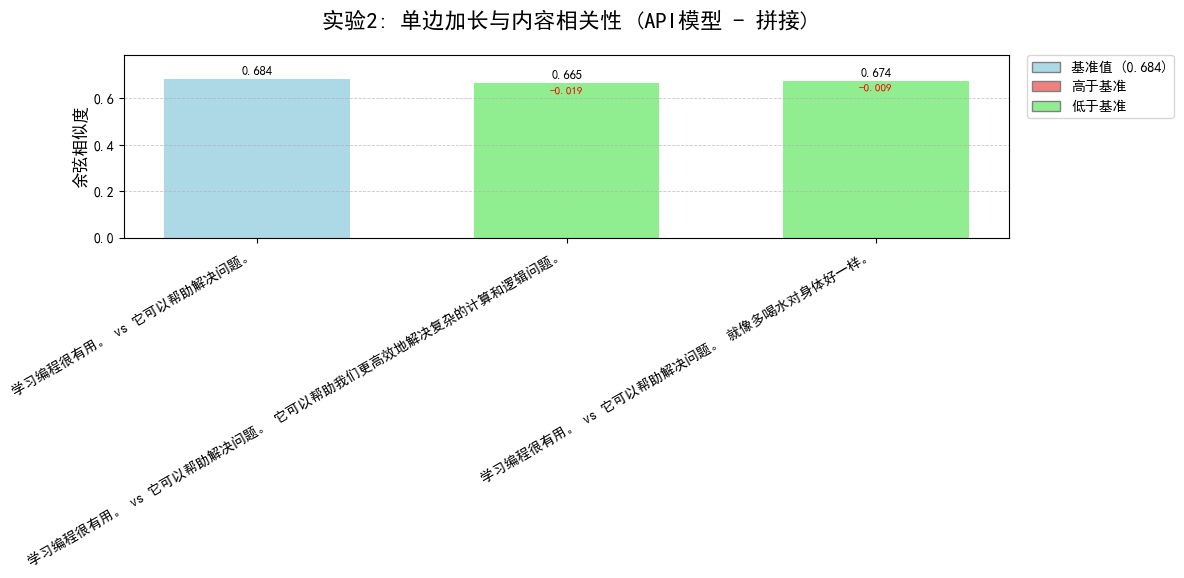

In [156]:
# 实验2: 单边加长与内容相关性 (优化版 - 拼接加长)

# 定义句子
s3_base = "学习编程很有用。"
s4_base = "它可以帮助解决问题。"
# s4 加长 - 相关 (拼接)
s4_long_append_relevant = s4_base + " 它可以帮助我们更高效地解决复杂的计算和逻辑问题。"
# s4 加长 - 不相关 (拼接)
s4_long_append_irrelevant = s4_base + " 就像多喝水对身体好一样。"

pairs_exp2 = [
    (s3_base, s4_base),                      # 基础对
    (s3_base, s4_long_append_relevant),     # s4 相关拼接加长
    (s3_base, s4_long_append_irrelevant),   # s4 不相关拼接加长
]

# 使用本地模型运行实验
res_exp2 = run_experiment(pairs_exp2, model_name=bge_m3_model_path, use_local=True)
print("实验2 本地模型结果:")
print(res_exp2)

# 可视化结果
plot_results(res_exp2, "实验2: 单边加长与内容相关性 (本地模型 - 拼接)")

# 使用API模型运行实验
res_exp2_api = run_experiment(pairs_exp2, model_name="BAAI/bge-m3", use_local=False)
print("\n实验2 API模型结果:")
print(res_exp2_api)
# 可视化结果
plot_results(res_exp2_api, "实验2: 单边加长与内容相关性 (API模型 - 拼接)")


实验3 本地模型结果:
{'他正在准备考试。 vs 她也在复习功课。': 0.7646497488021851, '他正在准备考试。 他在图书馆里认真准备即将到来的期末考试。 vs 她也在复习功课。 她在自己的房间里系统地复习这学期的功课笔记。': 0.6684635877609253}


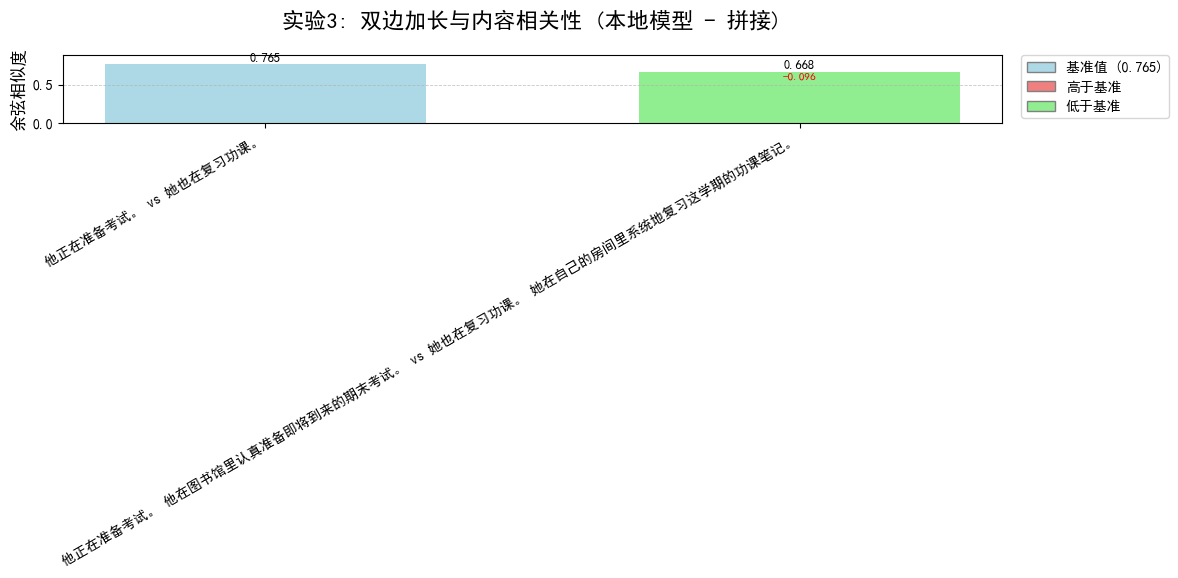


实验3 API模型结果:
{'他正在准备考试。 vs 她也在复习功课。': 0.7645334408762892, '他正在准备考试。 他在图书馆里认真准备即将到来的期末考试。 vs 她也在复习功课。 她在自己的房间里系统地复习这学期的功课笔记。': 0.667634523487496}


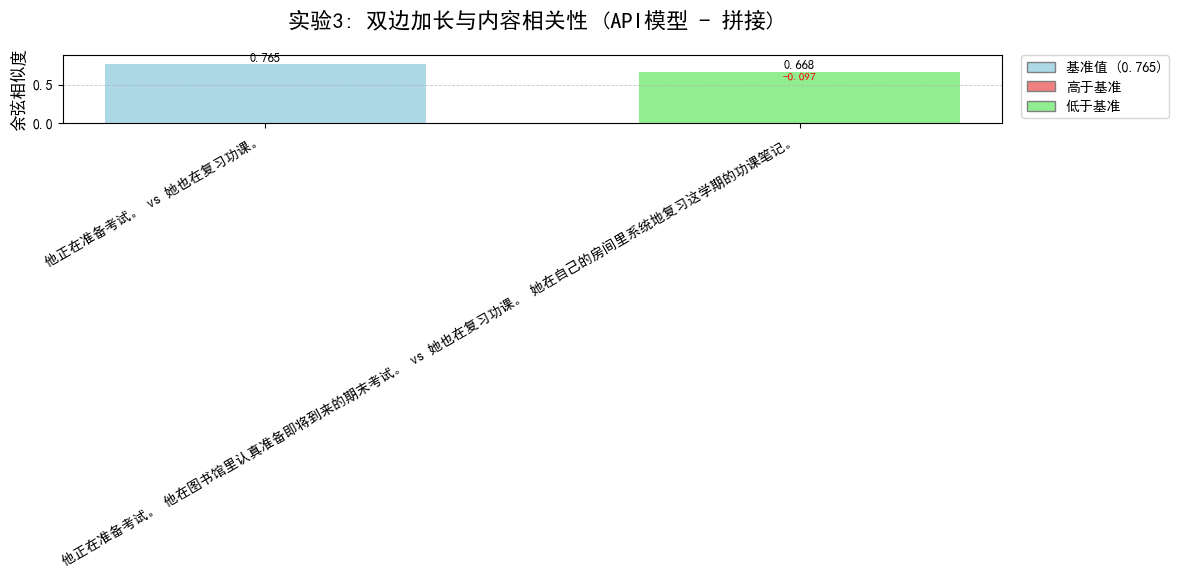

In [157]:
# 实验3: 双边加长与内容相关性 (优化版 - 拼接加长)

# 定义句子
s5_base = "他正在准备考试。"
s6_base = "她也在复习功课。"
# 双边加长 (拼接)
s5_long_append = s5_base + " 他在图书馆里认真准备即将到来的期末考试。"
s6_long_append = s6_base + " 她在自己的房间里系统地复习这学期的功课笔记。"

pairs_exp3 = [
    (s5_base, s6_base),               # 基础对
    (s5_long_append, s6_long_append), # 双边拼接加长
]

# 使用本地模型运行实验
res_exp3 = run_experiment(pairs_exp3, model_name=bge_m3_model_path, use_local=True)
print("实验3 本地模型结果:")
print(res_exp3)

# 可视化结果
plot_results(res_exp3, "实验3: 双边加长与内容相关性 (本地模型 - 拼接)")

# 使用API模型运行实验
res_exp3_api = run_experiment(pairs_exp3, model_name="BAAI/bge-m3", use_local=False)
print("\n实验3 API模型结果:")
print(res_exp3_api)
# 可视化结果
plot_results(res_exp3_api, "实验3: 双边加长与内容相关性 (API模型 - 拼接)")

实验4 本地模型结果:
{'运动有益健康。 vs 饮食也很重要。': 0.6831406950950623, '运动有益健康。 坚持适度的体育运动能够增强心肺功能。 vs 饮食也很重要。 均衡营养的饮食习惯对于维持身体健康至关重要。': 0.7203255295753479, '运动有益健康。 尤其是在风景优美的公园里进行。 vs 饮食也很重要。 特别是在装修豪华的餐厅里享用。': 0.608267605304718}


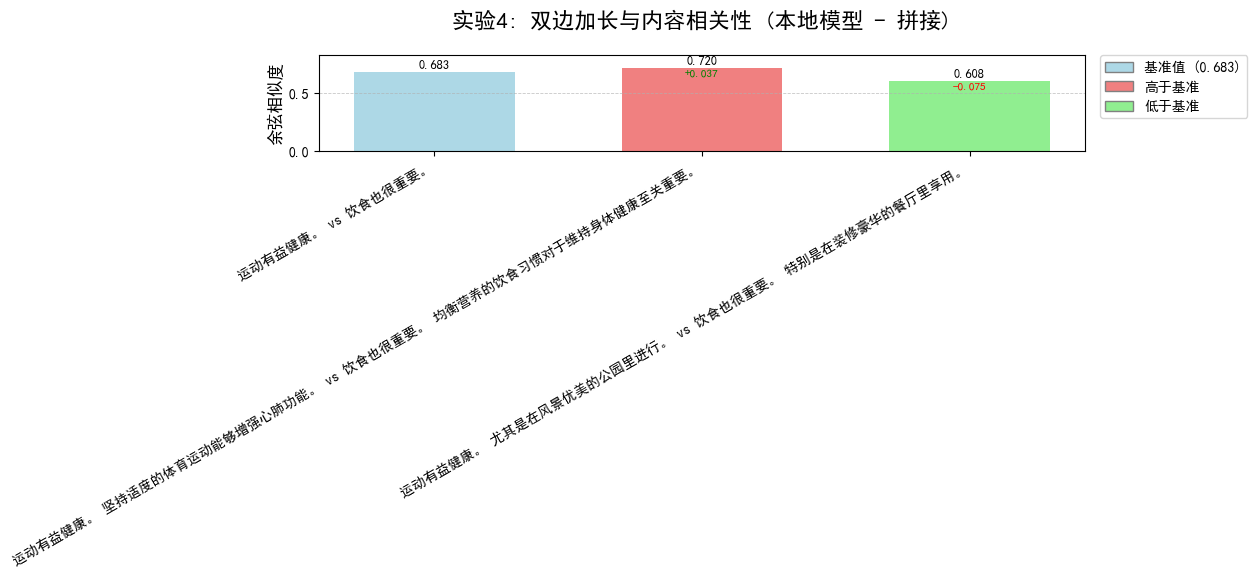


实验4 API模型结果:
{'运动有益健康。 vs 饮食也很重要。': 0.6827373840992088, '运动有益健康。 坚持适度的体育运动能够增强心肺功能。 vs 饮食也很重要。 均衡营养的饮食习惯对于维持身体健康至关重要。': 0.7205349437044848, '运动有益健康。 尤其是在风景优美的公园里进行。 vs 饮食也很重要。 特别是在装修豪华的餐厅里享用。': 0.6077622019784221}


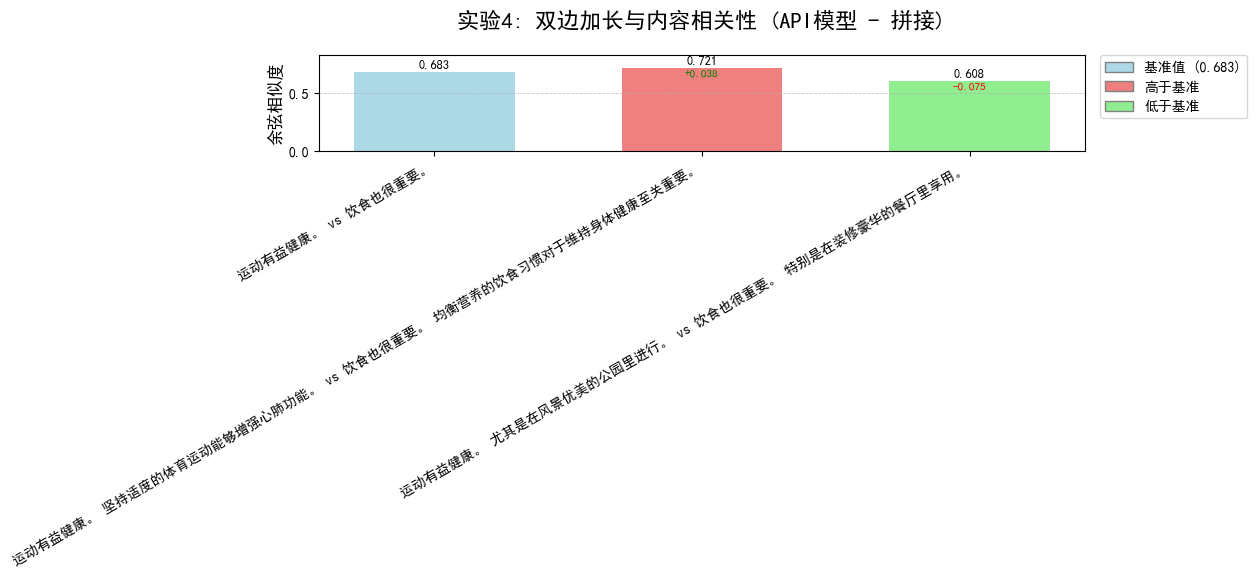

In [158]:
# 实验4: 双边加长与内容相关性 (相关/不相关) (优化版 - 拼接加长)

# 定义句子
s7_base = "运动有益健康。"
s8_base = "饮食也很重要。"

# --- 双边相关加长 (拼接) ---
s7_long_append_relevant = s7_base + " 坚持适度的体育运动能够增强心肺功能。"
s8_long_append_relevant = s8_base + " 均衡营养的饮食习惯对于维持身体健康至关重要。"

# --- 双边不相关加长 (拼接) ---
s7_long_append_irrelevant = s7_base + " 尤其是在风景优美的公园里进行。"
s8_long_append_irrelevant = s8_base + " 特别是在装修豪华的餐厅里享用。"

pairs_exp4 = [
    (s7_base, s8_base),                                  # 基础对
    (s7_long_append_relevant, s8_long_append_relevant), # 双边相关拼接加长
    (s7_long_append_irrelevant, s8_long_append_irrelevant), # 双边不相关拼接加长
]

# 使用本地模型运行实验
res_exp4_local = run_experiment(pairs_exp4, model_name=bge_m3_model_path, use_local=True)
print("实验4 本地模型结果:")
print(res_exp4_local)

# 可视化结果 (本地)
plot_results(res_exp4_local, "实验4: 双边加长与内容相关性 (本地模型 - 拼接)")

# 使用API模型运行实验
res_exp4_api = run_experiment(pairs_exp4, model_name="BAAI/bge-m3", use_local=False)
print("\n实验4 API模型结果:")
print(res_exp4_api)

# 可视化结果 (API)
plot_results(res_exp4_api, "实验4: 双边加长与内容相关性 (API模型 - 拼接)")

In [159]:

jina_model_path = "C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/jina-embeddings-v3"
bge_m3_model_path = "C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-m3"
bge_large_zh_v1_5_model_path = "C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-large-zh-v1.5"


--- Running Experiment 1 with BGE-M3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-m3) ---
{'小狗在追球。 vs 小狗在玩耍。': 0.8268042206764221, '小狗在追球。 它在公园的草地上兴奋地追逐一个红色的球。 vs 小狗在玩耍。': 0.7518507242202759}


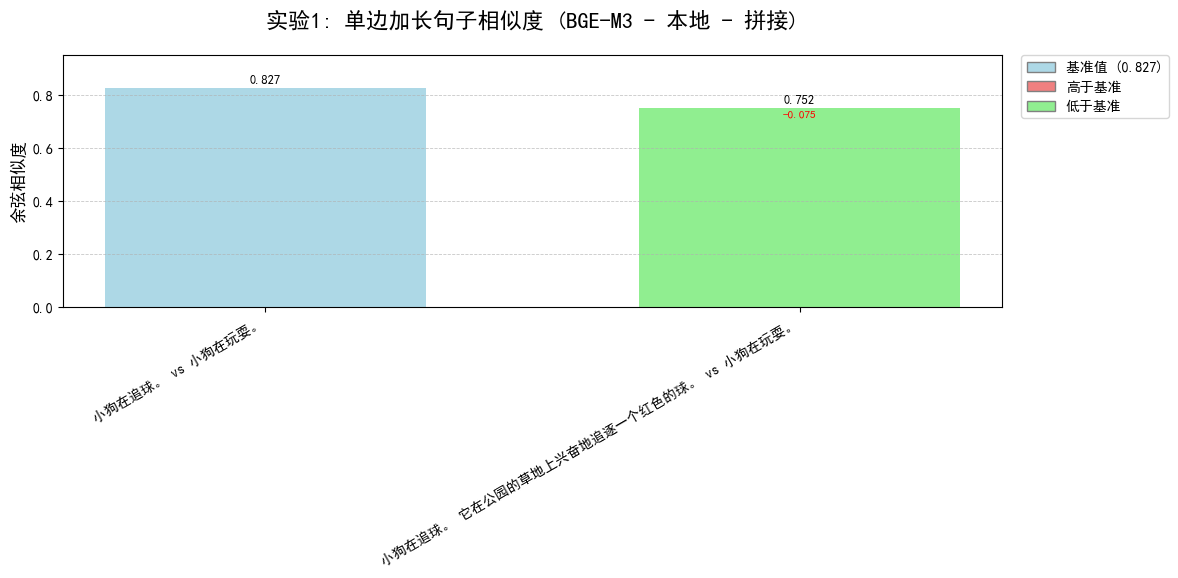

--- Running Experiment 1 with BGE-Large-ZH-v1.5 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-large-zh-v1.5) ---
{'小狗在追球。 vs 小狗在玩耍。': 0.8004240989685059, '小狗在追球。 它在公园的草地上兴奋地追逐一个红色的球。 vs 小狗在玩耍。': 0.6766746044158936}


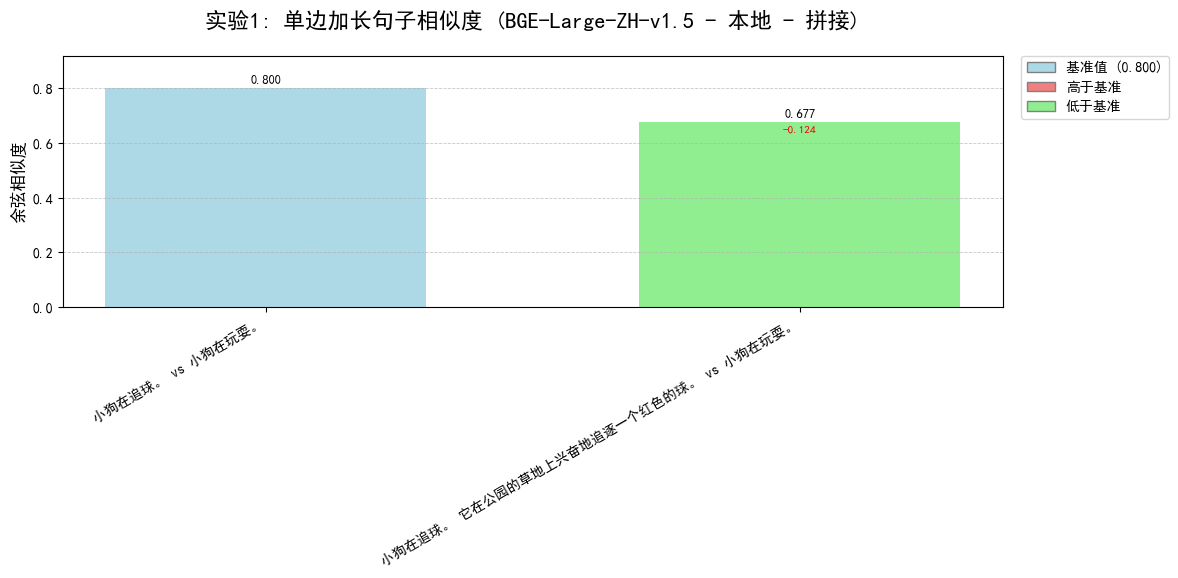

--- Running Experiment 1 with Jina-Embeddings-v3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/jina-embeddings-v3) ---
{'小狗在追球。 vs 小狗在玩耍。': 0.7809606790542603, '小狗在追球。 它在公园的草地上兴奋地追逐一个红色的球。 vs 小狗在玩耍。': 0.7417886257171631}


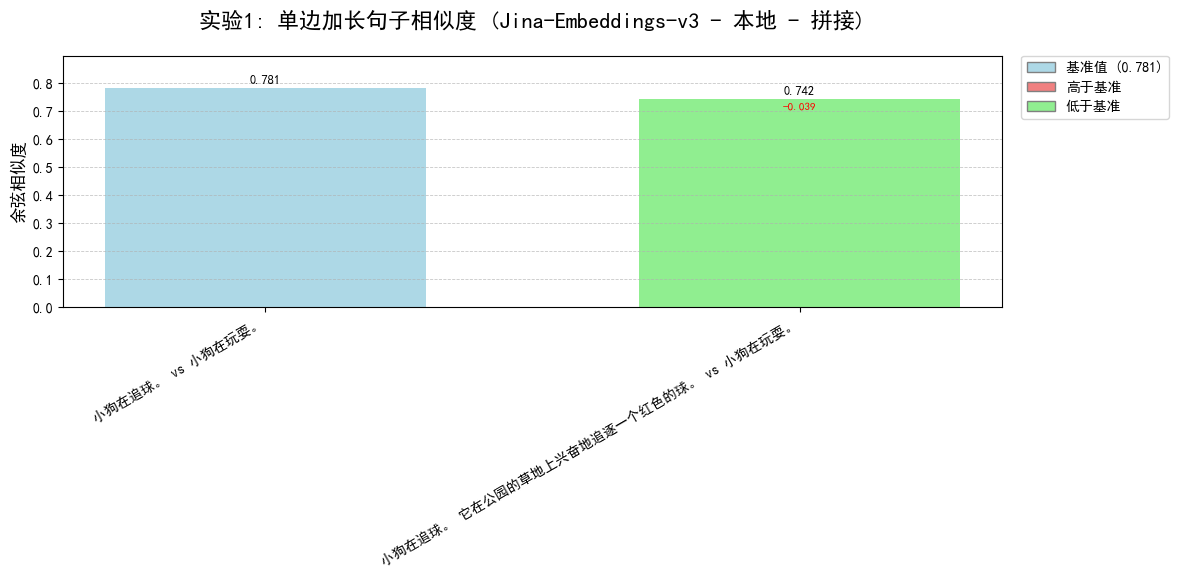

In [160]:
# 分别使用不同模型进行实验1 (使用优化后的 pairs - 拼接)

# 定义要测试的本地模型路径和名称
local_models = {
    "BGE-M3": bge_m3_model_path,
    "BGE-Large-ZH-v1.5": bge_large_zh_v1_5_model_path,
    "Jina-Embeddings-v3": jina_model_path
}

# 循环运行实验并可视化
for model_nickname, model_path in local_models.items():
    print(f"--- Running Experiment 1 with {model_nickname} ({model_path}) ---")
    # pairs 变量来自 Cell [7] (实验1定义处, 已优化为拼接)
    res_exp1_local = run_experiment(pairs, model_name=model_path, use_local=True)
    print(res_exp1_local)
    plot_results(res_exp1_local, f"实验1: 单边加长句子相似度 ({model_nickname} - 本地 - 拼接)")


--- Running Experiment 2 with BGE-M3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-m3) ---
{'学习编程很有用。 vs 它可以帮助解决问题。': 0.6839863657951355, '学习编程很有用。 vs 它可以帮助解决问题。 它可以帮助我们更高效地解决复杂的计算和逻辑问题。': 0.6648806929588318, '学习编程很有用。 vs 它可以帮助解决问题。 就像多喝水对身体好一样。': 0.6743142008781433}


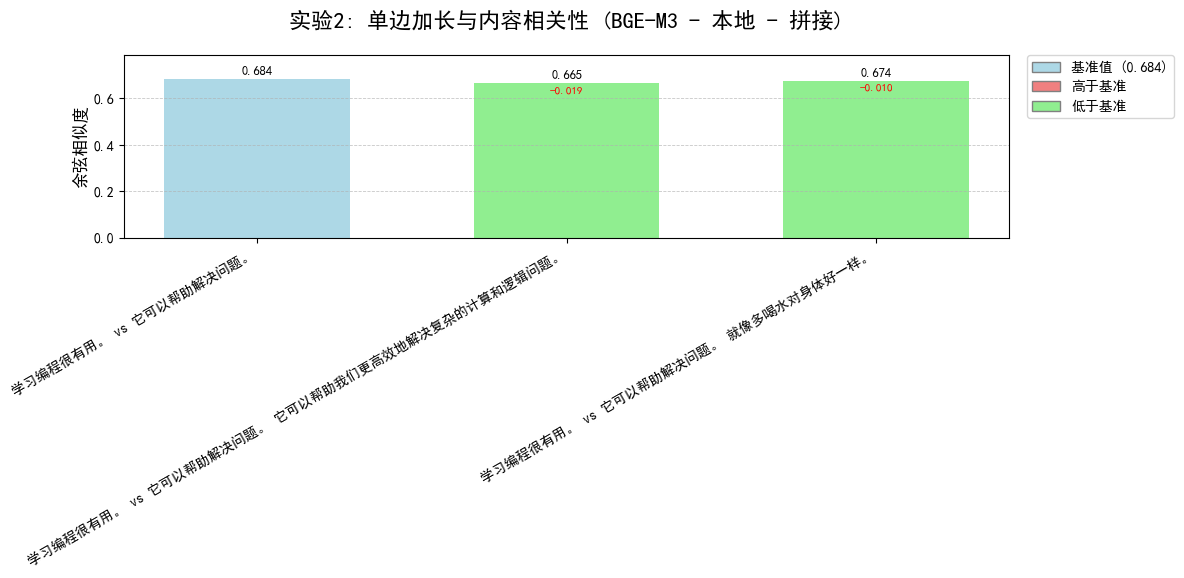

--- Running Experiment 2 with BGE-Large-ZH-v1.5 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-large-zh-v1.5) ---
{'学习编程很有用。 vs 它可以帮助解决问题。': 0.625311017036438, '学习编程很有用。 vs 它可以帮助解决问题。 它可以帮助我们更高效地解决复杂的计算和逻辑问题。': 0.6582375764846802, '学习编程很有用。 vs 它可以帮助解决问题。 就像多喝水对身体好一样。': 0.5503785610198975}


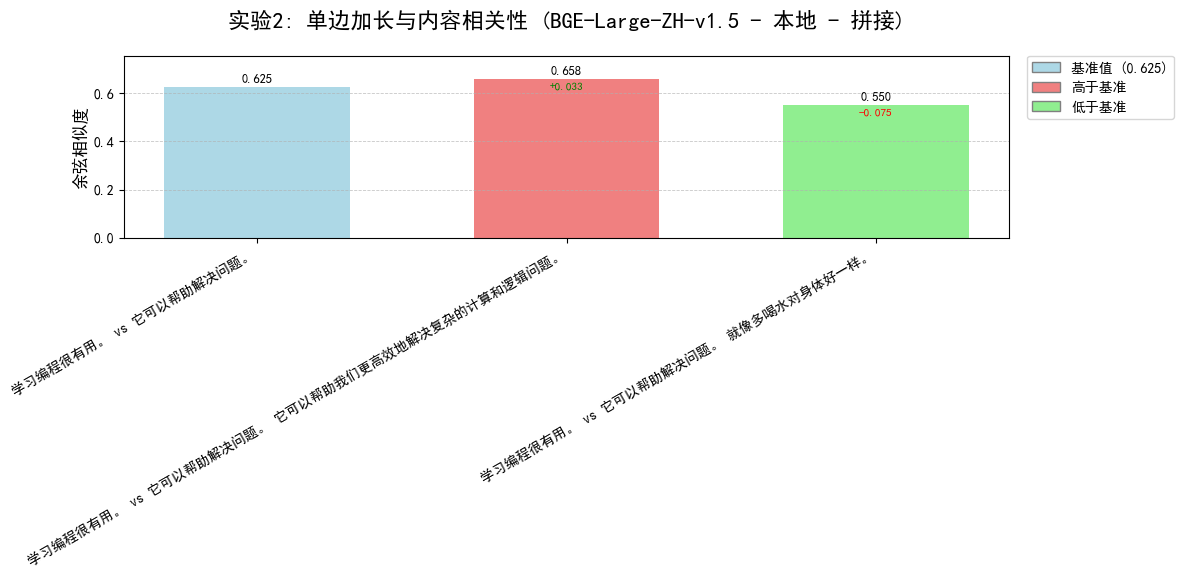

--- Running Experiment 2 with Jina-Embeddings-v3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/jina-embeddings-v3) ---
{'学习编程很有用。 vs 它可以帮助解决问题。': 0.5905976295471191, '学习编程很有用。 vs 它可以帮助解决问题。 它可以帮助我们更高效地解决复杂的计算和逻辑问题。': 0.6478652954101562, '学习编程很有用。 vs 它可以帮助解决问题。 就像多喝水对身体好一样。': 0.5904194116592407}


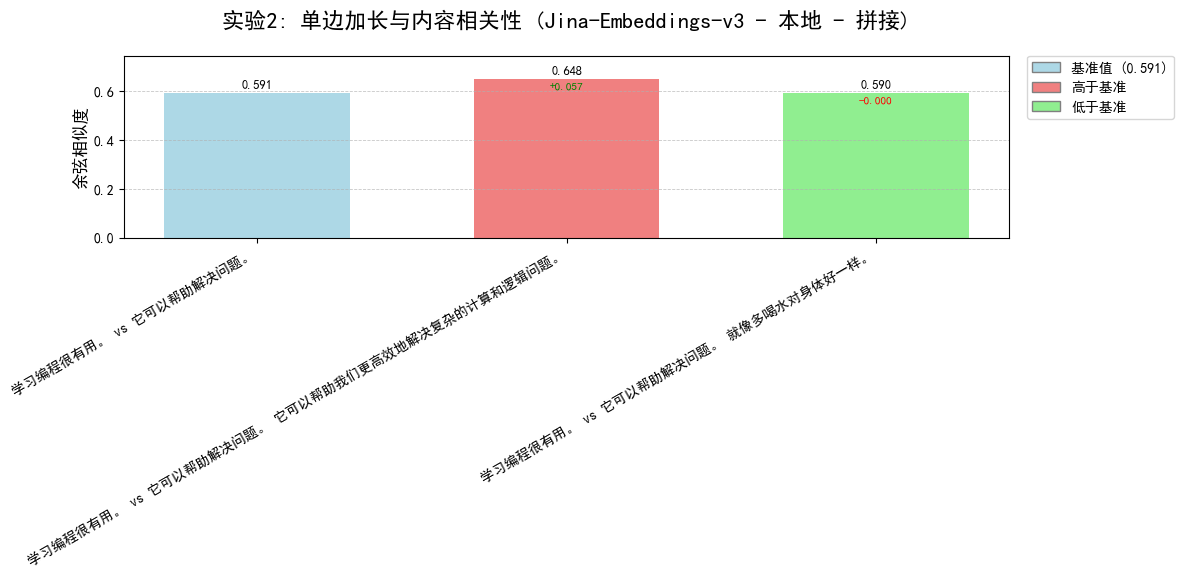

In [161]:
# 使用多个本地模型进行实验2 (使用优化后的 pairs_exp2 - 拼接)

# 循环运行实验并可视化
for model_nickname, model_path in local_models.items():
    print(f"--- Running Experiment 2 with {model_nickname} ({model_path}) ---")
    # pairs_exp2 变量来自 Cell [10] (实验2定义处, 已优化为拼接)
    res_exp2_local = run_experiment(pairs_exp2, model_name=model_path, use_local=True)
    print(res_exp2_local)
    plot_results(res_exp2_local, f"实验2: 单边加长与内容相关性 ({model_nickname} - 本地 - 拼接)")


--- Running Experiment 3 with BGE-M3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-m3) ---
{'他正在准备考试。 vs 她也在复习功课。': 0.7646497488021851, '他正在准备考试。 他在图书馆里认真准备即将到来的期末考试。 vs 她也在复习功课。 她在自己的房间里系统地复习这学期的功课笔记。': 0.6684635877609253}


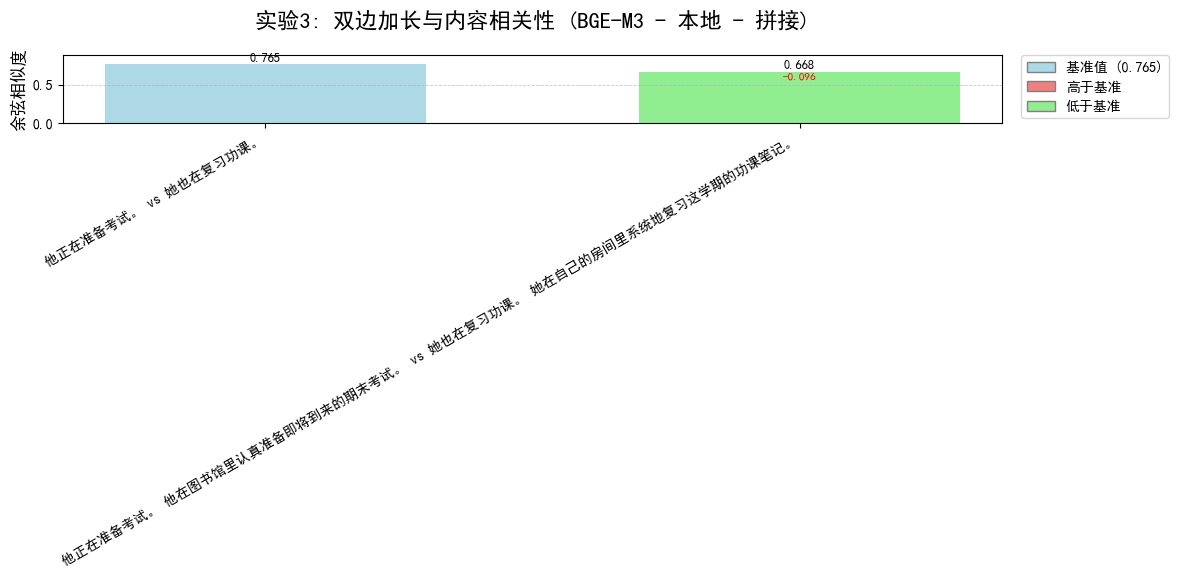

--- Running Experiment 3 with BGE-Large-ZH-v1.5 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-large-zh-v1.5) ---
{'他正在准备考试。 vs 她也在复习功课。': 0.6192346811294556, '他正在准备考试。 他在图书馆里认真准备即将到来的期末考试。 vs 她也在复习功课。 她在自己的房间里系统地复习这学期的功课笔记。': 0.5535777807235718}


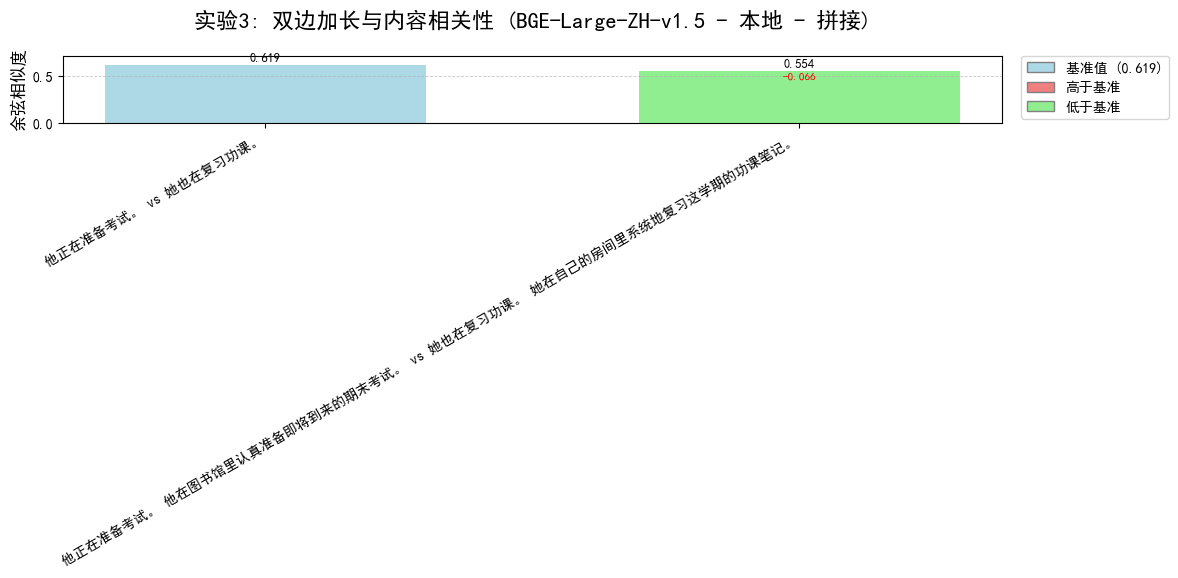

--- Running Experiment 3 with Jina-Embeddings-v3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/jina-embeddings-v3) ---
{'他正在准备考试。 vs 她也在复习功课。': 0.6537917852401733, '他正在准备考试。 他在图书馆里认真准备即将到来的期末考试。 vs 她也在复习功课。 她在自己的房间里系统地复习这学期的功课笔记。': 0.6751325130462646}


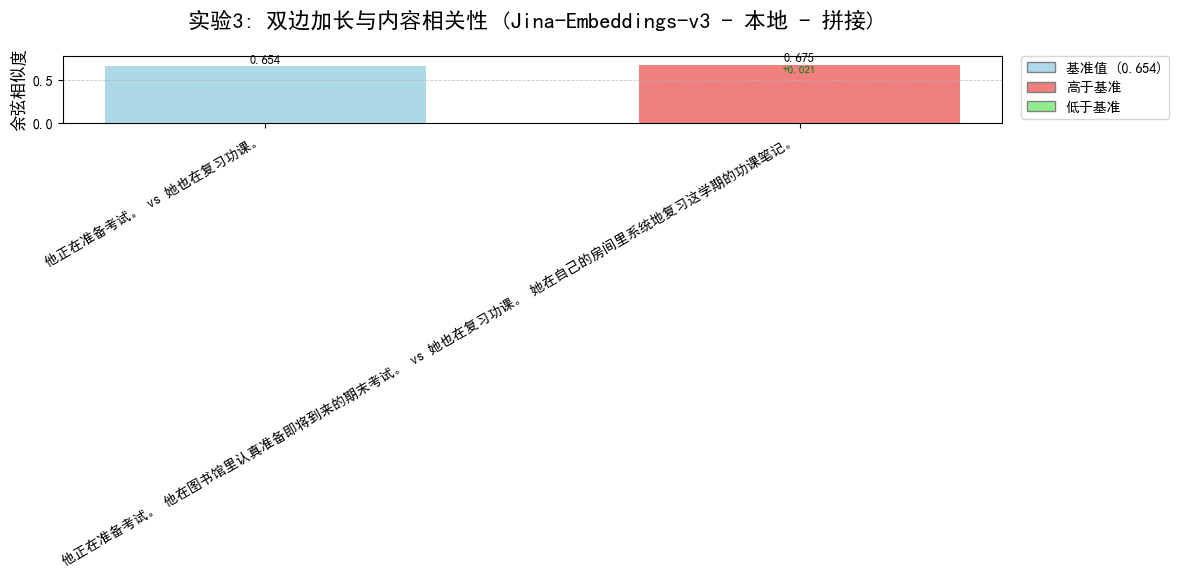

In [162]:
# 使用多个本地模型进行实验3 (使用优化后的 pairs_exp3 - 拼接)

# 循环运行实验并可视化
for model_nickname, model_path in local_models.items():
    print(f"--- Running Experiment 3 with {model_nickname} ({model_path}) ---")
    # pairs_exp3 变量来自 Cell [11] (实验3定义处, 已优化为拼接)
    res_exp3_local = run_experiment(pairs_exp3, model_name=model_path, use_local=True)
    print(res_exp3_local)
    plot_results(res_exp3_local, f"实验3: 双边加长与内容相关性 ({model_nickname} - 本地 - 拼接)")


--- Running Experiment 4 with BGE-M3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-m3) ---
{'运动有益健康。 vs 饮食也很重要。': 0.6831406950950623, '运动有益健康。 坚持适度的体育运动能够增强心肺功能。 vs 饮食也很重要。 均衡营养的饮食习惯对于维持身体健康至关重要。': 0.7203255295753479, '运动有益健康。 尤其是在风景优美的公园里进行。 vs 饮食也很重要。 特别是在装修豪华的餐厅里享用。': 0.608267605304718}


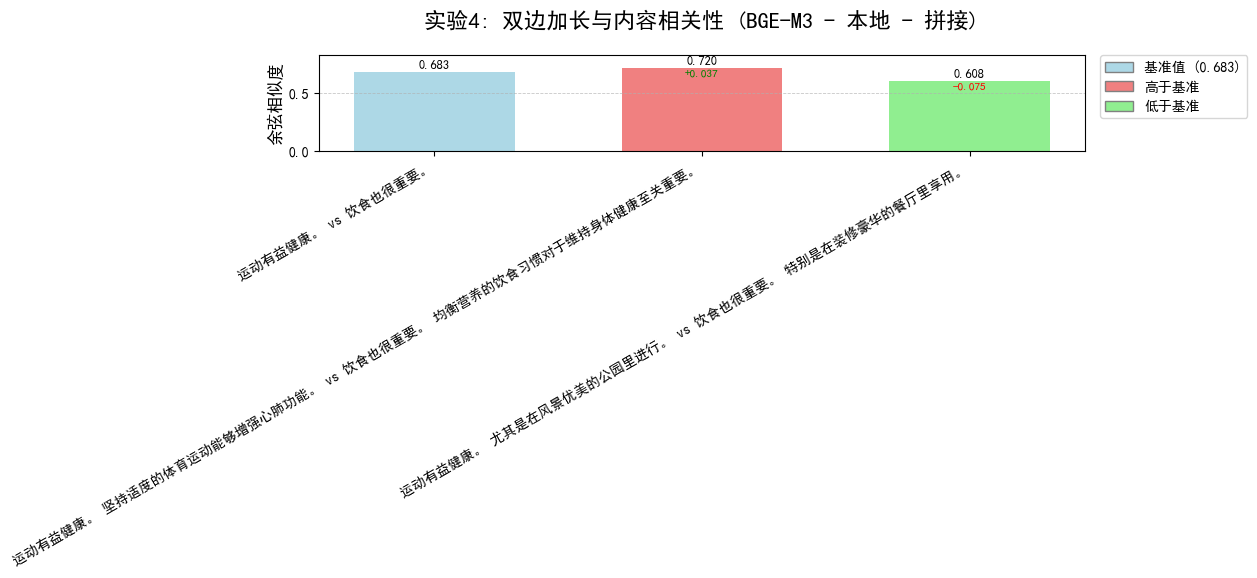

--- Running Experiment 4 with BGE-Large-ZH-v1.5 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-large-zh-v1.5) ---
{'运动有益健康。 vs 饮食也很重要。': 0.6062209606170654, '运动有益健康。 坚持适度的体育运动能够增强心肺功能。 vs 饮食也很重要。 均衡营养的饮食习惯对于维持身体健康至关重要。': 0.6141246557235718, '运动有益健康。 尤其是在风景优美的公园里进行。 vs 饮食也很重要。 特别是在装修豪华的餐厅里享用。': 0.42777717113494873}


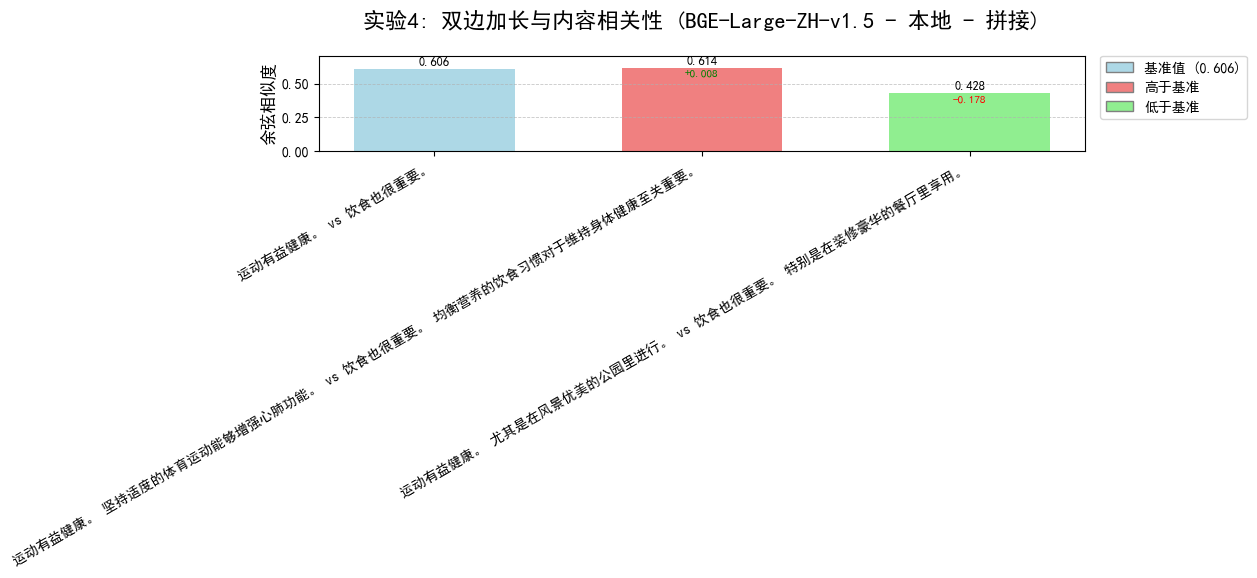

--- Running Experiment 4 with Jina-Embeddings-v3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/jina-embeddings-v3) ---
{'运动有益健康。 vs 饮食也很重要。': 0.5825772285461426, '运动有益健康。 坚持适度的体育运动能够增强心肺功能。 vs 饮食也很重要。 均衡营养的饮食习惯对于维持身体健康至关重要。': 0.5918487310409546, '运动有益健康。 尤其是在风景优美的公园里进行。 vs 饮食也很重要。 特别是在装修豪华的餐厅里享用。': 0.45225656032562256}


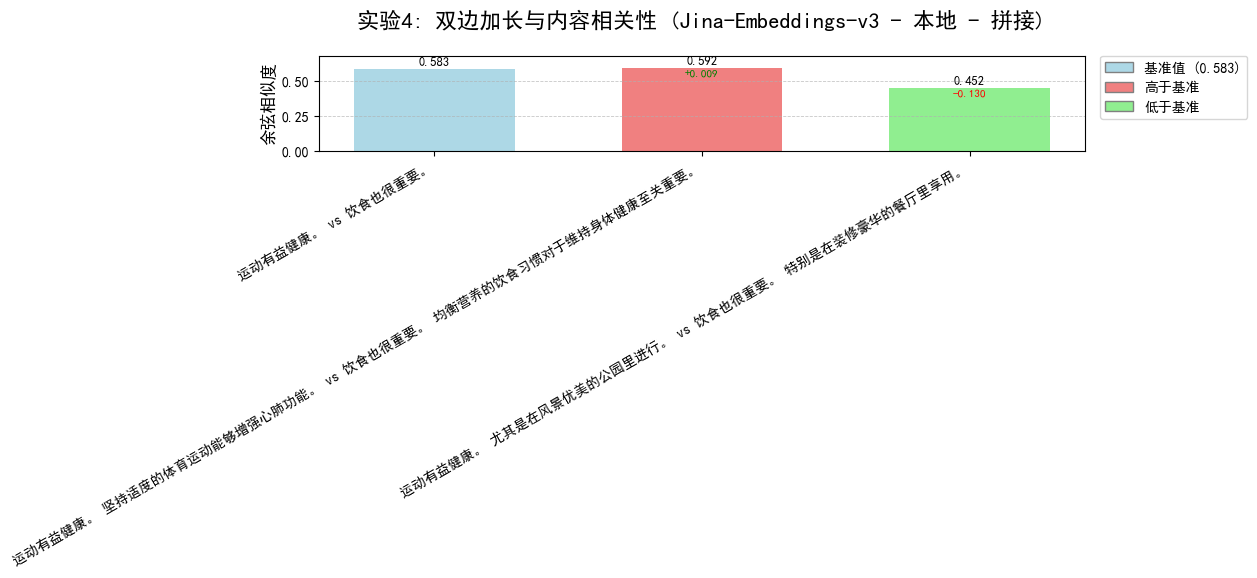

In [163]:
# 使用多个本地模型进行实验4 (使用优化后的 pairs_exp4 - 拼接)

# 循环运行实验并可视化
for model_nickname, model_path in local_models.items():
    print(f"--- Running Experiment 4 with {model_nickname} ({model_path}) ---")
    # pairs_exp4 变量来自 Cell [12] (实验4定义处, 已优化为拼接)
    res_exp4_local = run_experiment(pairs_exp4, model_name=model_path, use_local=True)
    print(res_exp4_local)
    plot_results(res_exp4_local, f"实验4: 双边加长与内容相关性 ({model_nickname} - 本地 - 拼接)")


实验5 本地模型结果:
{'人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。': 0.6811128854751587, '人工智能正在处于快速发展的时代。 vs 火山快速到达了爆发的临界点。': 0.49692946672439575, '机器学习在人工智能领域处于一个十分重要的地位。 vs 火山快速到达了爆发的临界点。': 0.3324572741985321, '人工智能正在处于快速发展的时代。 vs 人工智能这个词最近很火。': 0.8142959475517273, '机器学习在人工智能领域处于一个十分重要的地位。 vs 机器学习需要大量的计算资源。': 0.6463586688041687, '人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。 火山快速到达了爆发的临界点。': 0.6913666725158691, '人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。 火山到达了爆发的临界点。': 0.6715778708457947}


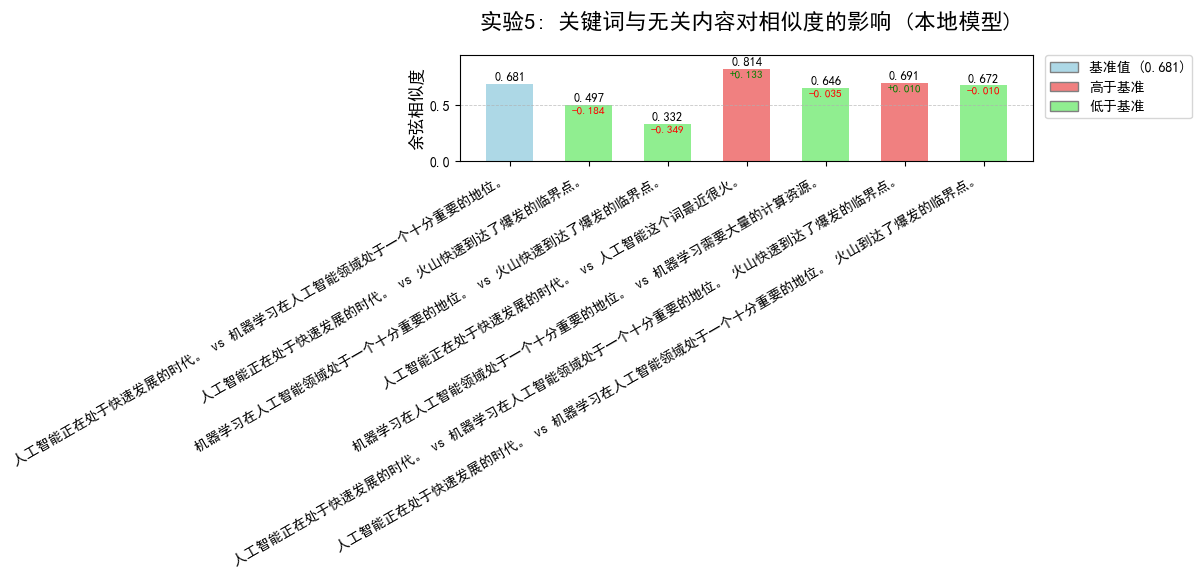


实验5 API模型结果:
{'人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。': 0.6805832203054355, '人工智能正在处于快速发展的时代。 vs 火山快速到达了爆发的临界点。': 0.49616952792542796, '机器学习在人工智能领域处于一个十分重要的地位。 vs 火山快速到达了爆发的临界点。': 0.3317570230838466, '人工智能正在处于快速发展的时代。 vs 人工智能这个词最近很火。': 0.814189944351672, '机器学习在人工智能领域处于一个十分重要的地位。 vs 机器学习需要大量的计算资源。': 0.646433113290562, '人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。 火山快速到达了爆发的临界点。': 0.691005963660837, '人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。 火山到达了爆发的临界点。': 0.6710682208746349}


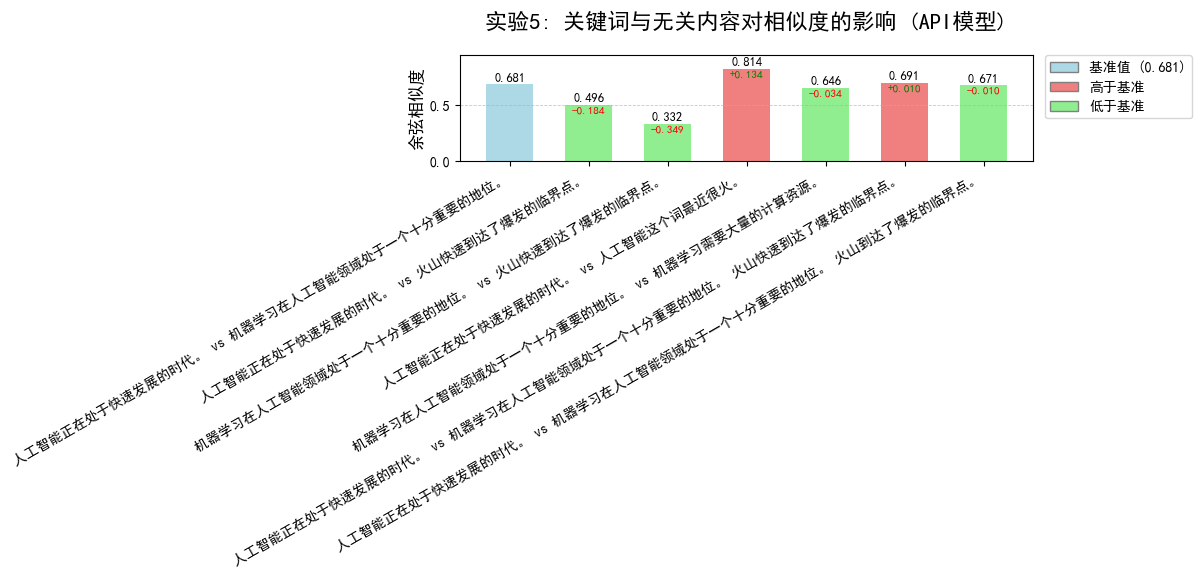

In [170]:
# 实验 5: 关键词重叠与无关内容对相似度的影响

# 定义句子
s9_ai_dev = "人工智能正在处于快速发展的时代。"
s10_ml_importance = "机器学习在人工智能领域处于一个十分重要的地位。"
s11_volcano = "火山快速到达了爆发的临界点。"

s12_ai_popularity = "人工智能这个词最近很火。"
s13_ml_resource = "机器学习需要大量的计算资源。"

s14_volcano = "火山到达了爆发的临界点。"

# 新增：在相关句子后添加完全不相关内容
s10_ml_volcano = s10_ml_importance + " " + s11_volcano

s15_ml_volcano = s10_ml_importance + " " + s14_volcano

pairs_exp5 = [
    (s9_ai_dev, s10_ml_importance),   # 共享关键词 (AI, ML)，主题相关
    (s9_ai_dev, s11_volcano),         # 无共享关键词，主题无关
    (s10_ml_importance, s11_volcano), # 无共享关键词，主题无关
    (s9_ai_dev, s12_ai_popularity),   # 共享关键词 (AI)，主题部分相关
    (s10_ml_importance, s13_ml_resource), # 共享关键词 (ML)，主题部分相关
    (s9_ai_dev, s10_ml_volcano) ,      # 共享关键词，但s10添加了完全无关内容
    (s9_ai_dev, s15_ml_volcano)   # 共享关键词，但s10添加了完全无关内容
]

# 使用本地模型运行实验
res_exp5_local = run_experiment(pairs_exp5, model_name=bge_m3_model_path, use_local=True)
print("实验5 本地模型结果:")
print(res_exp5_local)

# 可视化结果 (本地)
plot_results(res_exp5_local, "实验5: 关键词与无关内容对相似度的影响 (本地模型)")

# 使用API模型运行实验
res_exp5_api = run_experiment(pairs_exp5, model_name="BAAI/bge-m3", use_local=False)
print("\n实验5 API模型结果:")
print(res_exp5_api)

# 可视化结果 (API)
plot_results(res_exp5_api, "实验5: 关键词与无关内容对相似度的影响 (API模型)")

--- Running Experiment 5 with BGE-M3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-m3) ---
{'人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。': 0.6811128854751587, '人工智能正在处于快速发展的时代。 vs 火山快速到达了爆发的临界点。': 0.49692946672439575, '机器学习在人工智能领域处于一个十分重要的地位。 vs 火山快速到达了爆发的临界点。': 0.3324572741985321, '人工智能正在处于快速发展的时代。 vs 人工智能这个词最近很火。': 0.8142959475517273, '机器学习在人工智能领域处于一个十分重要的地位。 vs 机器学习需要大量的计算资源。': 0.6463586688041687, '人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。 火山快速到达了爆发的临界点。': 0.6913666725158691, '人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。 火山到达了爆发的临界点。': 0.6715778708457947}


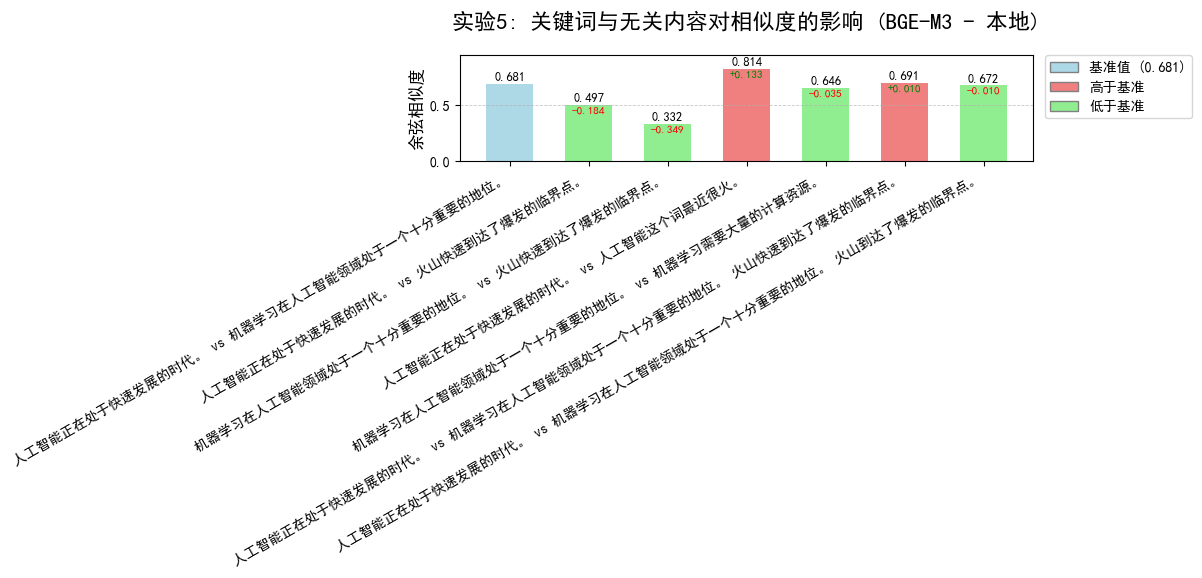

--- Running Experiment 5 with BGE-Large-ZH-v1.5 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-large-zh-v1.5) ---
{'人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。': 0.6805571913719177, '人工智能正在处于快速发展的时代。 vs 火山快速到达了爆发的临界点。': 0.5321683883666992, '机器学习在人工智能领域处于一个十分重要的地位。 vs 火山快速到达了爆发的临界点。': 0.3298811614513397, '人工智能正在处于快速发展的时代。 vs 人工智能这个词最近很火。': 0.7908591628074646, '机器学习在人工智能领域处于一个十分重要的地位。 vs 机器学习需要大量的计算资源。': 0.7248408198356628, '人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。 火山快速到达了爆发的临界点。': 0.6779122948646545, '人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。 火山到达了爆发的临界点。': 0.6317113041877747}


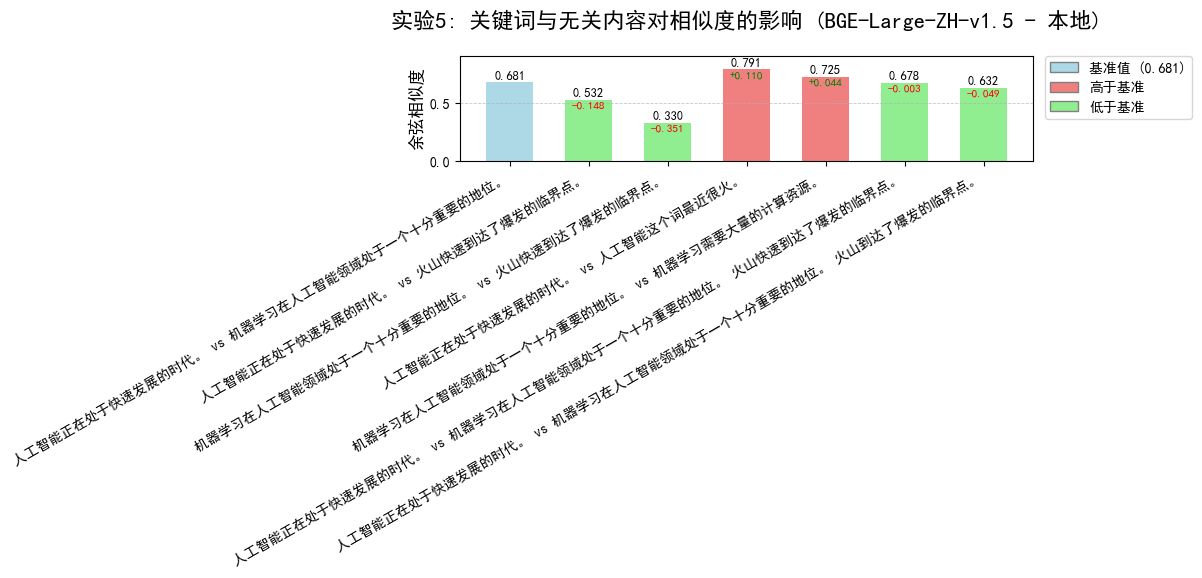

--- Running Experiment 5 with Jina-Embeddings-v3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/jina-embeddings-v3) ---
{'人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。': 0.7240262627601624, '人工智能正在处于快速发展的时代。 vs 火山快速到达了爆发的临界点。': 0.3613162338733673, '机器学习在人工智能领域处于一个十分重要的地位。 vs 火山快速到达了爆发的临界点。': 0.235630601644516, '人工智能正在处于快速发展的时代。 vs 人工智能这个词最近很火。': 0.8141775131225586, '机器学习在人工智能领域处于一个十分重要的地位。 vs 机器学习需要大量的计算资源。': 0.7788192629814148, '人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。 火山快速到达了爆发的临界点。': 0.705029308795929, '人工智能正在处于快速发展的时代。 vs 机器学习在人工智能领域处于一个十分重要的地位。 火山到达了爆发的临界点。': 0.7074109315872192}


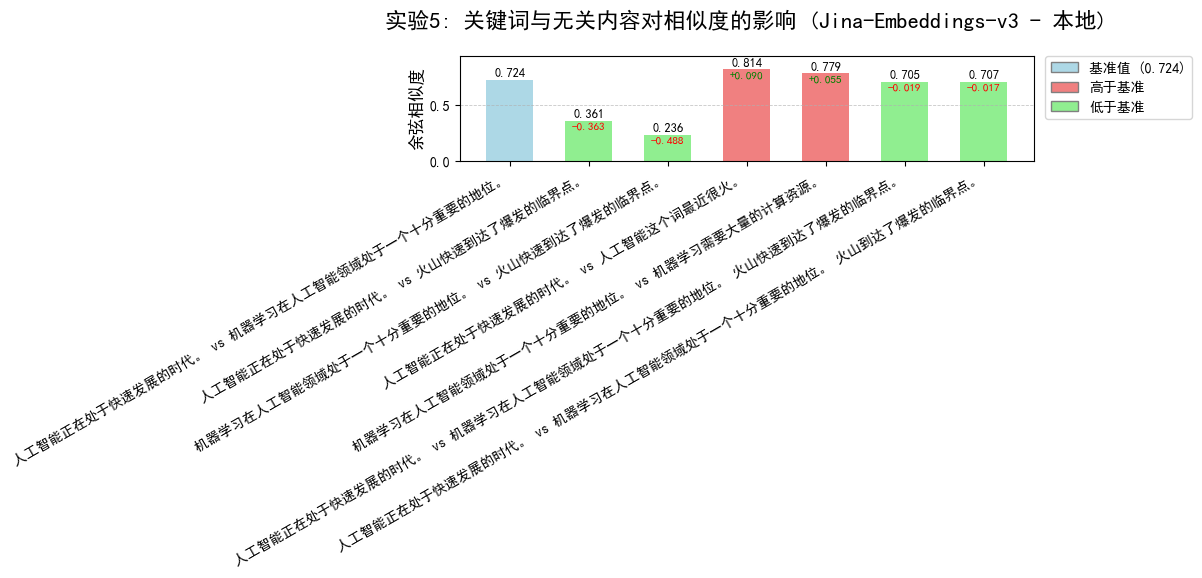

In [171]:
# 使用多个本地模型进行实验5 (使用 pairs_exp5)

# 循环运行实验并可视化
for model_nickname, model_path in local_models.items():
    print(f"--- Running Experiment 5 with {model_nickname} ({model_path}) ---")
    # pairs_exp5 变量来自上一个单元格 (实验5定义处)
    res_exp5_local_multi = run_experiment(pairs_exp5, model_name=model_path, use_local=True)
    print(res_exp5_local_multi)
    plot_results(res_exp5_local_multi, f"实验5: 关键词与无关内容对相似度的影响 ({model_nickname} - 本地)")


# 实验总结

本项目通过五个实验，探究了句子长度、内容相关性以及关键词重叠对句子向量相似度的影响。所有实验均采用拼接方式进行句子加长，并对比了本地模型和 API 模型的表现。

## 实验 1: 单边加长句子
*   **目的**: 观察将一个句子通过拼接方式加长后，与另一个句子的相似度变化。
*   **方法**: 对比基础句子对 `(s1_base, s2_base)` 和单边加长后的句子对 `(s1_long_append, s2_base)` 的相似度。

## 实验 2: 单边加长与内容相关性
*   **目的**: 探究单边加长时，添加相关内容与添加不相关内容对相似度的不同影响。
*   **方法**: 对比基础对 `(s3_base, s4_base)` 与分别添加相关内容 `(s3_base, s4_long_append_relevant)` 和不相关内容 `(s3_base, s4_long_append_irrelevant)` 后的相似度。

## 实验 3: 双边加长与内容相关性
*   **目的**: 观察将两个句子都通过拼接方式加长后，它们之间的相似度变化。
*   **方法**: 对比基础句子对 `(s5_base, s6_base)` 和双边加长后的句子对 `(s5_long_append, s6_long_append)` 的相似度。

## 实验 4: 双边加长与内容相关性 (相关/不相关)
*   **目的**: 探究双边加长时，同时添加相关内容与同时添加不相关内容对相似度的不同影响。
*   **方法**: 对比基础对 `(s7_base, s8_base)` 与分别同时添加相关内容 `(s7_long_append_relevant, s8_long_append_relevant)` 和不相关内容 `(s7_long_append_irrelevant, s8_long_append_irrelevant)` 后的相似度。

## 实验 5: 关键词重叠与无关内容
*   **目的**: 检验关键词重叠对相似度的影响，以及在存在关键词重叠的情况下，添加完全无关内容是否会显著降低相似度。
*   **方法**: 设计了多组句子对，包括：
    *   共享关键词且主题相关
    *   无共享关键词且主题无关
    *   共享关键词但主题部分相关
    *   共享关键词但其中一个句子添加了完全无关的内容（火山例子）
    通过对比这些句子对的相似度，分析关键词和无关信息的作用。

# 实验观察与初步结论 (基于测试数据)

根据上述五个实验在不同本地模型 (BGE-M3, BGE-Large-ZH-v1.5, Jina-Embeddings-v3) 上的运行结果，可以观察到以下现象：

1.  **单边句子加长的影响**:
    *   在实验 1 中，所有测试模型（BGE-M3, BGE-Large, Jina-v3）均显示，当对一个句子进行拼接加长（添加相关细节）后，其与另一个基础句子的相似度均出现**下降**。
        *   BGE-M3: 0.827 -> 0.752
        *   BGE-Large: 0.800 -> 0.677
        *   Jina-v3: 0.781 -> 0.742
    *   这表明单边增加信息量（即使是相关的）可能会稀释核心语义或改变句子向量的方向，导致与原对应句子的相似度降低。

2.  **内容相关性在单边加长中的作用 (实验 2)**:
    *   **BGE-M3**: 添加相关内容 (0.684 -> 0.665) 和不相关内容 (0.684 -> 0.674) 均导致相似度**下降**，且添加相关内容下降幅度略大。
    *   **BGE-Large/Jina**: 添加相关内容使相似度**上升** (Large: 0.625 -> 0.658; Jina: 0.591 -> 0.648)，而添加不相关内容则导致相似度**下降** (Large: -> 0.550; Jina: -> 0.590)。
    *   结论：模型对此反应不一。对于 BGE-Large 和 Jina，内容相关性符合预期，相关内容增强联系，不相关内容削弱联系。BGE-M3 对任何形式的单边加长都表现出相似度下降的趋势，对相关性不敏感甚至负相关。

3.  **双边相关内容加长的影响 (实验 3)**:
    *   **BGE-M3 / BGE-Large**: 双边添加相关细节导致相似度**下降** (M3: 0.765 -> 0.668; Large: 0.619 -> 0.554)。
    *   **Jina-v3**: 双边添加相关细节导致相似度**上升** (0.654 -> 0.675)。
    *   结论：模型差异显著。Jina 模型似乎能从双边补充的相关信息中获益，增强语义联系；而 BGE 模型则可能因信息增加带来的向量变化而降低了相似度。

4.  **内容相关性在双边加长中的作用 (实验 4)**:
    *   **所有模型**: 双边添加**相关**内容均使相似度**上升** (M3: 0.683 -> 0.720; Large: 0.606 -> 0.614; Jina: 0.583 -> 0.592)。
    *   **所有模型**: 双边添加**不相关**内容均使相似度**显著下降** (M3: -> 0.608; Large: -> 0.428; Jina: -> 0.452)。
    *   结论：在此场景下，模型表现一致且符合直觉。双边强化相关主题能提升相似度，而双边引入无关主题则会严重破坏句子对的语义联系。

5.  **关键词重叠与无关“噪音”信息的影响 (实验 5)**:
    *   **关键词作用**: 共享核心关键词（如“人工智能”、“机器学习”）对相似度得分有**巨大提升**作用。即使主题不完全重合（如 “人工智能正在处于快速发展的时代。” vs “人工智能这个词最近很火。”），高关键词重叠也能带来极高的相似度（普遍 > 0.79）。无关键词重叠且主题无关的句子对（如 “人工智能正在处于快速发展的时代。” vs “火山快速到达了爆发的临界点。”, “机器学习在人工智能领域处于一个十分重要的地位。” vs “火山快速到达了爆发的临界点。”）相似度则非常低（普遍 < 0.54，甚至 < 0.37）。
    *   **噪音鲁棒性**: 对比 (“人工智能正在处于快速发展的时代。”, “机器学习在人工智能领域处于一个十分重要的地位。”) 和 (“人工智能正在处于快速发展的时代。”, “机器学习在人工智能领域处于一个十分重要的地位。 火山快速到达了爆发的临界点。”)，在 “机器学习在人工智能领域处于一个十分重要的地位。” 后添加完全无关的“火山”信息后：
        *   BGE-M3: 相似度略微**上升** (0.681 -> 0.691)。
        *   BGE-Large: 相似度略微**下降** (0.681 -> 0.678)。
        *   Jina-v3: 相似度略微**下降** (0.724 -> 0.705)。
    *   结论：关键词是影响相似度的强信号。同时，模型对在强相关信号基础上添加的少量无关“噪音”信息表现出一定的**鲁棒性**，相似度并未崩溃。BGE-M3 对噪音的反应（略微上升）值得注意。

6.  **模型间的共性与差异总结**:
    *   **共性**: 所有模型对强关键词信号（Exp 5）、双边添加不相关内容（Exp 4）的反应趋势一致。
    *   **差异**: 对于单边/双边添加**相关**内容（Exp 1, 2, 3），模型的反应存在显著差异。Jina 模型似乎更倾向于从补充的相关信息中提升相似度，而 BGE-M3 对任何形式的加长都可能导致相似度下降，BGE-Large 介于两者之间。

**初步结论**: 句子向量相似度受多种因素共同影响，包括核心语义、句子长度变化、附加内容的相关性、关键词重叠度以及所选用的嵌入模型。简单地增加句子长度（即使内容相关）并不总能提升相似度，其效果依赖于具体模型和加长方式（单边/双边）。关键词匹配对相似度贡献显著。模型在一定程度上能抵抗少量无关信息的干扰。在实际应用中，解释相似度得分需谨慎，要结合文本的具体情况和模型的特性进行综合判断。

实验1 API模型结果:
{'小狗在追球。 vs 小狗在玩耍。': 0.8262612468012507, '小狗在追球。 它在公园的草地上兴奋地玩耍一个红色的球。 vs 小狗在玩耍。': 0.7808643019261126, '小狗在追球。 vs 小狗在玩耍。 它在公园的草地上兴奋地追逐一个红色的球。': 0.7839397836392819, '小狗在追球。 它在公园的草地上兴奋地玩耍一个红色的球。 vs 小狗在追球。 小狗在公园的草地上兴奋地追逐一个红色的球。': 0.9726853563598148}


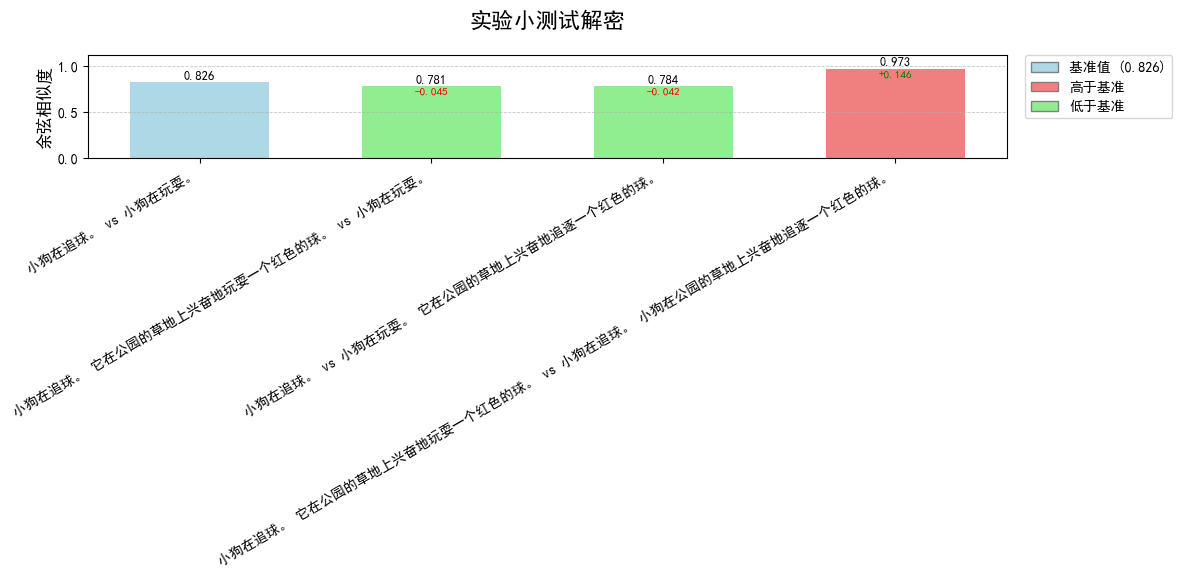

In [175]:
# 实验小测试解密

# 基础对
s1_base = "小狗在追球。"
s2_base = "小狗在玩耍。"
# 单边加长 (拼接)
s1_long_append = s1_base + " 它在公园的草地上兴奋地玩耍一个红色的球。"
s2_long_append = s2_base + " 它在公园的草地上兴奋地追逐一个红色的球。"
s3_long_append = s1_base + " 小狗在公园的草地上兴奋地追逐一个红色的球。"
pair_tests = [
    (s1_base, s2_base),           # 基础对
    (s1_long_append, s2_base),    # s1 拼接加长
    (s1_base, s2_long_append),    # s2 拼接加长
    (s1_long_append, s3_long_append), # s1 拼接加长，s3 拼接加长
]

# 使用API模型运行实验 (示例)
res = run_experiment(pair_tests, model_name="BAAI/bge-m3", use_local=False)
print("实验1 API模型结果:")
print(res)
# 可视化
plot_results(res, "实验小测试解密")

--- Running Experiment with BGE-M3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-m3) ---
{'小狗在追球。 vs 小狗在玩耍。': 0.8268042206764221, '小狗在追球。 它在公园的草地上兴奋地玩耍一个红色的球。 vs 小狗在玩耍。': 0.781149685382843, '小狗在追球。 vs 小狗在玩耍。 它在公园的草地上兴奋地追逐一个红色的球。': 0.7843018770217896, '小狗在追球。 它在公园的草地上兴奋地玩耍一个红色的球。 vs 小狗在追球。 小狗在公园的草地上兴奋地追逐一个红色的球。': 0.9727877378463745}


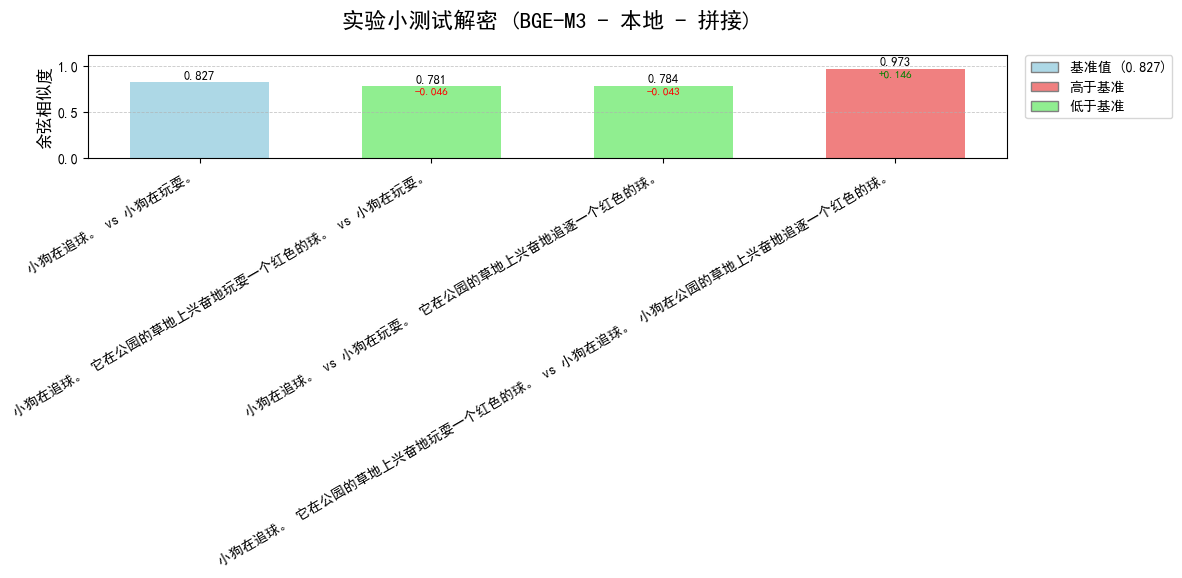

--- Running Experiment with BGE-Large-ZH-v1.5 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/bge-large-zh-v1.5) ---
{'小狗在追球。 vs 小狗在玩耍。': 0.8004240989685059, '小狗在追球。 它在公园的草地上兴奋地玩耍一个红色的球。 vs 小狗在玩耍。': 0.7024315595626831, '小狗在追球。 vs 小狗在玩耍。 它在公园的草地上兴奋地追逐一个红色的球。': 0.7601181268692017, '小狗在追球。 它在公园的草地上兴奋地玩耍一个红色的球。 vs 小狗在追球。 小狗在公园的草地上兴奋地追逐一个红色的球。': 0.9792463183403015}


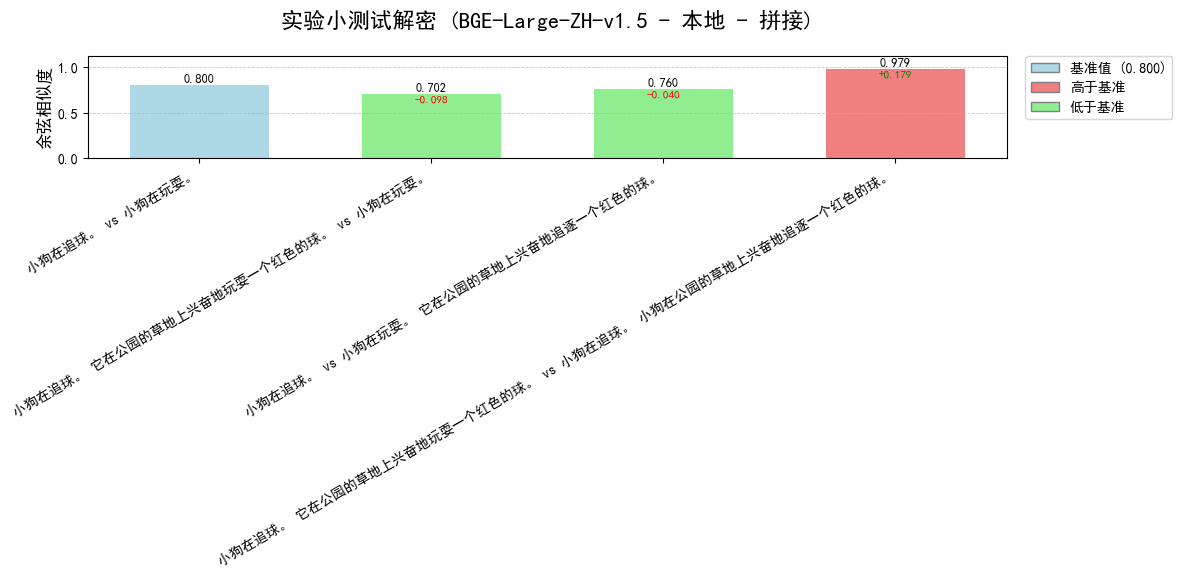

--- Running Experiment with Jina-Embeddings-v3 (C:/Users/k/Desktop/BaiduSyncdisk/baidu_sync_documents/hf_models/jina-embeddings-v3) ---
{'小狗在追球。 vs 小狗在玩耍。': 0.7809606790542603, '小狗在追球。 它在公园的草地上兴奋地玩耍一个红色的球。 vs 小狗在玩耍。': 0.7655760049819946, '小狗在追球。 vs 小狗在玩耍。 它在公园的草地上兴奋地追逐一个红色的球。': 0.8142569065093994, '小狗在追球。 它在公园的草地上兴奋地玩耍一个红色的球。 vs 小狗在追球。 小狗在公园的草地上兴奋地追逐一个红色的球。': 0.9728494882583618}


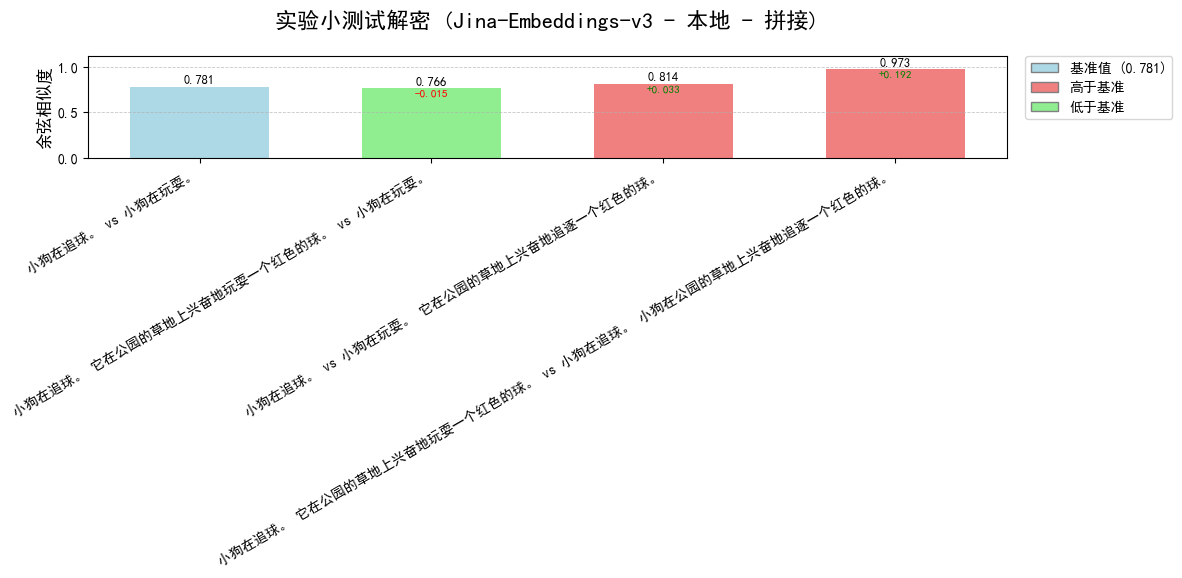

In [176]:
# 使用本地模型运行实验 (示例) 遍历模型

for model_nickname, model_path in local_models.items():
    print(f"--- Running Experiment with {model_nickname} ({model_path}) ---")
    # pairs 变量来自 Cell [7] (实验1定义处, 已优化为拼接)
    res_exp1_local = run_experiment(pair_tests, model_name=model_path, use_local=True)
    print(res_exp1_local)
    plot_results(res_exp1_local, f"实验小测试解密 ({model_nickname} - 本地 - 拼接)")